# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner 


<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

<div class='exercise'><b> Question 1 [50 pts]: Modeling seasonality of Airbnb prices </b></div>

In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

**1.1** Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`


**1.2** Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.


**1.3** Explore different regression models. Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method. Make sure to fit your model on *all training set observations*. Do not average or otherwise combine the data before fitting.


*Important*: Convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

* **1.3.1** Fit simple polynomial models of degree 2, 3, 5, and 8 via the `statsmodels` library to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

* **1.3.2** You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

* **1.3.3** Fit a penalized B-spline using `pygam` with the smoothness parameter chosen by cross-validation on the training set.  Again, provide the train and test scores of the best-performing model and plot its predictions.

* **1.3.4** Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?


**1.4** It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit. Create a binary indicator of weekend versus non-weekend, and include it in your additive model based on `pygam`.  How does it impact the model's performance?  

*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


**1.5** You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices. Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?


**1.1** Start by loading the data using pandas.
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`



In [14]:
# your code here
cal_train = pd.read_csv("data/calendar_train.csv", parse_dates=['date'])
cal_test = pd.read_csv("data/calendar_test.csv", parse_dates=['date'])
cal_train

,listing_id,date,available,price
0,20872145,2018-09-21,f,NaN
1,20872145,2018-09-19,f,NaN
2,20872145,2018-09-18,f,NaN
3,20872145,2018-09-17,f,NaN
4,20872145,2018-09-16,f,NaN
...,...,...,...,...
733998,4759640,2017-12-21,f,NaN
733999,4759640,2017-12-20,f,NaN
734000,4759640,2017-12-19,f,NaN
734001,4759640,2017-12-18,f,NaN


**1.2** Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.



In [48]:
# your code here
# Add month/day of week columns
cal_train['month']=pd.to_datetime(cal_train['date']).dt.month
cal_train['weekday']=pd.to_datetime(cal_train['date']).dt.dayofweek

<AxesSubplot:xlabel='month'>

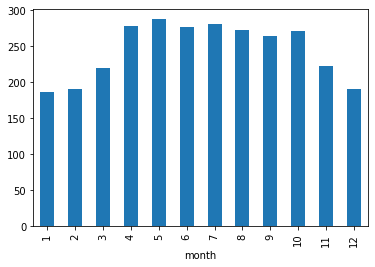

In [49]:
cal_train.groupby('month').price.mean().plot.bar()

<AxesSubplot:xlabel='weekday'>

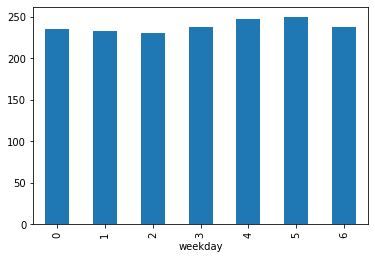

In [50]:
cal_train.groupby('weekday').price.mean().plot.bar()

*When plotting by month, the average price decreases in the late autumn/winter months, and increases in the summer. When plotting by day of the week, the average price increases on Friday and Saturday, and is lower on the other days of the week. These trends make sense since we would expect the best weather in Boston to be in the spring, summer, and fall and lead to more tourists, causing a price rise. Similarly, on the weekends we would expect more people to be coming into Boston for vacation, with a corresponding price rise.*

**1.3** Explore different regression models. Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method. Make sure to fit your model on *all training set observations*. Do not average or otherwise combine the data before fitting.


*Important*: Convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

**1.3.1** Fit simple polynomial models of degree 2, 3, 5, and 8 via the `statsmodels` library to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.



In [60]:
# Convert date into numerical variable for train and test
min_date_train = cal_train['date'].min()
cal_train['date_num'] = (cal_train['date'] - min_date_train).dt.days

min_date_test = cal_test['date'].min()
cal_test['date_num'] = (cal_test['date'] - min_date_test).dt.days

,listing_id,date,available,price,date_num
0,21205442,2018-09-28,t,138.0,357
1,5166870,2018-08-11,t,210.0,309
2,9698823,2017-10-17,f,NaN,11
3,18894466,2018-02-21,f,NaN,138
4,6765855,2018-09-22,f,NaN,351
...,...,...,...,...,...
314567,2843445,2018-05-11,t,85.0,217
314568,17591837,2017-12-10,t,199.0,65
314569,19177794,2018-06-17,f,NaN,254
314570,5075267,2017-12-30,t,188.0,85


<AxesSubplot:xlabel='date_num', ylabel='date_mean'>

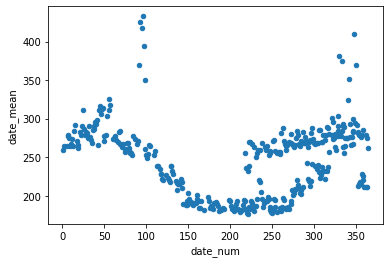

In [93]:
cal_train["date_mean"] = cal_train.groupby("date_num").price.mean()
cal_train.plot.scatter(x="date_num", y = "date_mean")

<AxesSubplot:xlabel='date_num', ylabel='date_mean'>

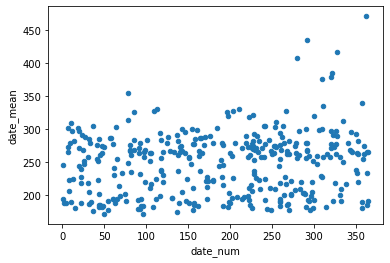

In [94]:
cal_test["date_mean"] = cal_test.groupby("date_num").price.mean()
cal_test.plot.scatter(x="date_num", y = "date_mean")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2913.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        23:26:13   Log-Likelihood:            -2.0564e+06
No. Observations:              309288   AIC:                         4.113e+06
Df Residuals:                  309285   BIC:                         4.113e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

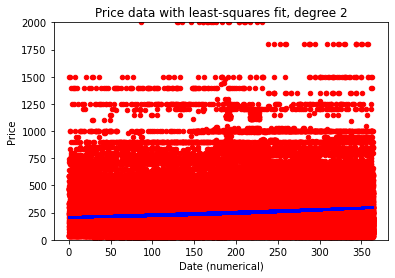

In [96]:
# Degree 2
plt.rcParams['agg.path.chunksize'] = 10000

fit2 = sm.ols(formula="price ~ np.vander(date_num, 3, increasing=True) -1",data=cal_train).fit()
pred2 = fit2.get_prediction(cal_test['date_num']).summary_frame()

ax2 = cal_test.plot.scatter(x='date_num',y='price',c='Red',title="Price data with least-squares fit, degree 2")
ax2.set_xlabel("Date (numerical)")
ax2.set_ylabel("Price")
ax2.axis(ymin=0, ymax=2000)


# CI for the prediction at each x value, i.e. the curve itself
ax2.plot(cal_test['date_num'], pred2['mean'],color="green")
ax2.plot(cal_test['date_num'], pred2['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(cal_test['date_num'], pred2['mean_ci_upper'], color="blue",linestyle="dashed")

In [95]:
pred2

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,293.445016,0.991816,291.501084,295.388947,-72.639044,659.529075
1,274.836224,0.590302,273.679248,275.993200,-91.244502,640.916951
2,207.023394,0.966699,205.128692,208.918095,-159.060408,573.107195
3,225.873209,0.464257,224.963279,226.783139,-140.206820,591.953238
4,291.002295,0.927441,289.184537,292.820053,-75.081116,657.085706
...,...,...,...,...,...,...
314567,245.130034,0.496832,244.156257,246.103811,-120.950159,611.210227
314568,213.213981,0.516806,212.201055,214.226906,-152.866319,579.294280
314569,256.135323,0.472001,255.210215,257.060431,-109.944744,622.215390
314570,216.191711,0.449096,215.311495,217.071927,-149.888245,582.271667


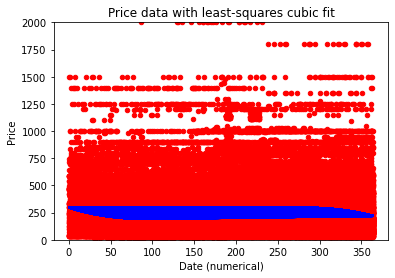

In [86]:
# Degree 3
fit3 = sm.ols(formula="price ~ np.vander(date_num, 4, increasing=True) -1",data=cal_train).fit()
pred3 = fit3.get_prediction(cal_test['date_num']).summary_frame()

ax3 = cal_test.plot.scatter(x='date_num',y='price',c='Red',title="Price data with least-squares fit, degree 3")
ax3.set_xlabel("Date (numerical)")
ax3.set_ylabel("Price")
ax3.axis(ymin=0, ymax=2000)

# CI for the prediction at each x value, i.e. the curve itself
ax3.plot(cal_test['date_num'], pred3['mean'],color="green")
ax3.plot(cal_test['date_num'], pred3['mean_ci_lower'], color="blue",linestyle="dashed")
ax3.plot(cal_test['date_num'], pred3['mean_ci_upper'], color="blue",linestyle="dashed")

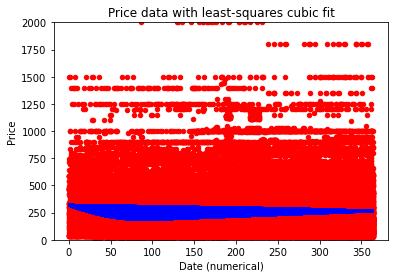

In [87]:
# Degree 5
fit5 = sm.ols(formula="price ~ np.vander(date_num, 6, increasing=True) -1",data=cal_train).fit()
pred5 = fit5.get_prediction(cal_test['date_num']).summary_frame()

ax5 = cal_test.plot.scatter(x='date_num',y='price',c='Red',title="Price data with least-squares fit, degree 5")
ax5.set_xlabel("Date (numerical)")
ax5.set_ylabel("Price")
ax5.axis(ymin=0, ymax=2000)

# CI for the prediction at each x value, i.e. the curve itself
ax5.plot(cal_test['date_num'], pred5['mean'],color="green")
ax5.plot(cal_test['date_num'], pred5['mean_ci_lower'], color="blue",linestyle="dashed")
ax5.plot(cal_test['date_num'], pred5['mean_ci_upper'], color="blue",linestyle="dashed")

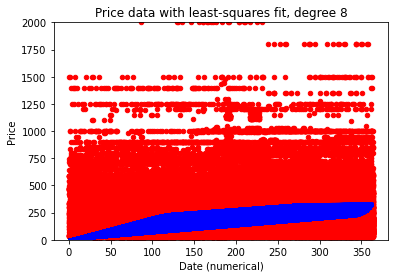

In [90]:
# Degree 8
fit8 = sm.ols(formula="price ~ np.vander(date_num, 9, increasing=True) -1",data=cal_train).fit()
pred8 = fit8.get_prediction(cal_test['date_num']).summary_frame()

ax8 = cal_test.plot.scatter(x='date_num',y='price',c='Red',title="Price data with least-squares fit, degree 8")
ax8.set_xlabel("Date (numerical)")
ax8.set_ylabel("Price")
ax8.axis(ymin=0, ymax=2000)

# CI for the prediction at each x value, i.e. the curve itself
ax8.plot(cal_test['date_num'], pred8['mean'],color="green")
ax8.plot(cal_test['date_num'], pred8['mean_ci_lower'], color="blue",linestyle="dashed")
ax8.plot(cal_test['date_num'], pred8['mean_ci_upper'], color="blue",linestyle="dashed")

In [102]:
print("R^2 for degree 2: " + str(fit2.rsquared))
print("R^2 for degree 3: " + str(fit3.rsquared))
print("R^2 for degree 5: " + str(fit5.rsquared))
print("R^2 for degree 8: " + str(fit8.rsquared))

R^2 for degree 2: 0.0184885736874294
R^2 for degree 3: 0.03893294505042599
R^2 for degree 5: 0.04210025453270427
R^2 for degree 8: -0.17019496979770965


*Your answer here*

**1.3.2** You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?


*Your answer here*

**1.3.3** Fit a penalized B-spline using `pygam` with the smoothness parameter chosen by cross-validation on the training set.  Again, provide the train and test scores of the best-performing model and plot its predictions.


In [13]:
# your code here


**1.3.4** Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?


*Your answer here*

**1.4** It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit. Create a binary indicator of weekend versus non-weekend, and include it in your additive model based on `pygam`.  How does it impact the model's performance?

*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.



In [16]:
# your code here


*Your answer here*

**1.5** You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices. Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [19]:
# your code here


*Your answer here*

<div class='exercise'><b> Question 2 [50 pts]: Predicting Airbnb Rental Price Through Listing Features </b></div>

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

**2.1** First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?


**2.2** Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e. basis functions $x, x^2, x^3$ for each predictor $x$) for quantitative predictors.

**2.3** Do you expect any advantage in fitting an additive model to these data, compared to the above models?

**2.4** Fit an additive model using the `pygam` library to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a penalized B-spline basis function on each predictor, tuned using cross-validation on the training set.

**2.5** Plot and examine the smooth of each predictor for the fitted additive model. What are some useful insights conveyed by these plots?

**2.6** Using the outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

**2.1** First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?



In [20]:
# your code here


*Your answer here*

**2.2** Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e. basis functions $x, x^2, x^3$ for each predictor $x$) for quantitative predictors.


In [25]:
# your code here


*Your answer here*

**2.3** Do you expect any advantage in fitting an additive model to these data, compared to the above models?


*Your answer here*

**2.4** Fit an additive model using the `pygam` library to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a penalized B-spline basis function on each predictor, tuned using cross-validation on the training set.


In [28]:
# your code here


**2.5** Plot and examine the smooth of each predictor for the fitted additive model. What are some useful insights conveyed by these plots?


In [29]:
# your code here


*Your answer here*

**2.6** Using the outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

*Your answer here*